# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 결정 트리

SVM처럼 <b>결정 트리</b><sup>decision tree</sup>는 분류와 회귀 작업 그리고 다중출력 작업도 가능한 다재다능한 머신러닝 알고리즘이다. 또한 데이터의 스케일링이나 정규화 등의 사전 가공의 영향이 매우 적다. 하지만 예측 성능을 향상시키기 위해 복잡한 규칙 구조를 가져야 하며, 이로 인한 과대적합이 발생해 반대로 예측 성능이 저하될 수도 있다. 하지만 이러한 단점이 앙상블 기법에서는 오히려 장점으로 작용한다.

결정 트리는 또한 설명이 중요할 때 아주 유용한 모델이다. 결정 트리라는 이름처럼 일련의 질문에 대한 결정을 통해 데이터를 분해하는 모델로 생각할 수 있다. 이와 같은 이유로 학습한 모델을 시각화하여 사람이 해석할 수 있다는 점이 가장 큰 특성이다.

다음은 앞에서 언급한 것 외에 추가적인 특성이다.

<ul>
    <li>범주형 변수나 데이터의 누락값(계측 오류 등으로 값이 존재하지 않는 경우)이 있어도 용인된다.</li>
    <li>비선형 문제에는 적용할 수 있지만, 선형 분리 문제는 잘 풀지 못한다.</li>
    <li>데이터 분포가 특정 클래스에 쏠려 있으면 잘 풀지 못한다.</li>
    <li>데이터의 작은 변화에도 결과가 크게 바뀌기 쉽다.</li>
    <li>예측 성능은 보통이다.</li>
    <li>배치 학습으로만 학습할 수 있다.</li>
 </ul>

이 장에서는 결정 트리의 훈련, 시각화, 예측 방법에 대해 먼저 살펴보겠다. 그런 다음 사이킷런의 CART 훈련 알고리즘을 둘러보고 트리에 규제를 가하는 방법과 회귀 문제에 적용하는 방법을 배우도록 하겠다. 마지막으로 결정 트리의 제약 사항에 관해 이야기하겠다.

## 개요

결정 트리는 훈련 데이터에 있는 특성을 기반으로 샘플의 클래스 레이블을 추정할 수 있는 일련의 질문을 학습한다. 따라서 데이터의 어떤 기준을 바탕으로 질문을 만들어야 가장 효율적인 분류가 될 것인가가 알고리즘의 성능을 크게 좌우한다. 이 질문은 범주형 변수는 물론 실수형 특성에도 적용된다. 예를 들어 꽃받침 너비 특성 축에 기준 값을 정하고 "꽃받침 너비가 2.8cm보다 큰가?"라는 예/아니요 질문을 할 수 있다.

결정 알고리즘을 사용하면 트리의 루트<sup>root</sup>에서 시작해서 <b>정보 이득</b><sup>Information Gatin, IG</sup>이 최대가 되는 특성으로 데이터를 나눈다. 정보 이득에 대해서는 후에 자세히 다룰 예정이다. 반복 과정을 통해 리프 노드<sup>leaf node</sup>가 순수해질 때까지 모든 자식 노드에서 이 분할 작업을 반복한다. 즉, 이 노드의 모든 샘플은 동일한 클래스에 속한다. 하지만 실제로 이렇게 하면 데이터를 조건 분기로 나눠가는 특성상, 노드가 많은 깊은 트리가 만들어지고 과대적합될 가능성이 높다. 즉, 트리의 깊이<sup>depth</sup>가 깊어질수록 결정 트리의 예측 성능이 저하될 가능성이 높다. 일반적으로 트리의 최대 깊이를 제한하여 트리를 <b>가지치기</b><sup>pruning</sup>한다.

특성 수가 많아도 과대적합을 일으키기 쉬우므로 미리 차원을 축소하거나 특성을 선별해주는 편이 좋다.

## 결정 트리 학습과 시각화

결정 트리를 이해하기 위해 모델 하나를 만들어서 어떻게 예측을 하는지 살펴보겠다. 다음은 붓꽃 데이터셋에 DecisionTreeClassifier를 훈련시키는 코드다.

In [44]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

<code>export_graphviz()</code> 함수를 사용해 그래프 정의를 iris_tree.dot 파일로 출력하여 훈련된 결정 트리를 시각화할 수 있다.

In [ ]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

우리가 만든 첫 번째 결정 트리는 [그림 1]과 같다.

<b>그림 1</b> 붓꽃 결정 트리
<div style="text-align:center;">
    <img src="./images/decision_trees/붓꽃 결정 트리.png">
</div>

## 예측하기

위의 트리가 어떻게 예측을 만들어내는지 살펴보겠다. 새로 발견한 붓꽃의 품종을 분류하려 한다고 가정하자. 먼저 <b>루트 노드</b><sup>root node</sup>(깊이가 0인 맨 꼭대기의 노드)에서 시작한다. 이 노드는 꽃잎의 길이가 2.45cm보다 짧은지 검사한다. 만약 그렇다면 루트 노드에서 왼쪽의 자식 노드<sup>child node</sup>(깊이 1, 왼쪽 노드)로 이동한다. 이 경우 이 노드가 <b>리프 노드</b><sup>leaf node</sup>(즉, 자식 노드를 가지지 않는 노드)이므로 추가적인 검사를 하지 않는다. 그냥 노드에 있는 예측 클래스를 보고 결정 트리가 새로 발견한 꽃의 품종을 Iris-Setosa(class=setosa)라고 예측한다.

또 다른 꽃을 발견했는데 이번에는 꽃잎의 길이가 2.45cm보다 길다. 이번에는 루트 노드의 오른쪽 자식 노드로 이동해야 한다. 이 노드는 리프 노드가 아니라서 추가로 '꽃잎의 너비가 1.75cm보다 작은지' 검사한다. 만약 그렇다면 이 꽃은 아마도 Iris-Versicolor(깊이 2, 왼쪽)일 것이다. 그렇지 않다면 Iris-Virginica(깊이 2, 오른쪽)일 것이다.

노드의 sample 속성은 얼마나 많은 훈련 샘플이 적용되었는지 헤아린 것이다. 예를 들어 100개의 훈련 샘플의 꽃잎 길이가 2.45cm보다 길고(깊이 1, 오른쪽), 그중 54개 샘플의 꽃잎 너비가 1.75cm보다 짧다(깊이 2, 왼쪽). 노드의 value 속성은 노드에서 각 클래스에 얼마나 많은 훈련 샘플이 있는지 알려준다. 예를 들어 맨 오른쪽 아래 노드는 Iris-Setosa가 0개이고, Iris-Versicolor가 1개, Iris-Virginica가 45개 있다는 의미다. 마지막으로 노드의 gini 속성은 <b>불순도</b><sup>impurity</sup>를 측정한다. 한 노드의 모든 샘플이 같은 클래스에 속해 있다면 이 노드를 순수(gini=0)하다고 한다. 예를 들어 깊이 1의 왼쪽 노드는 Iris-Setosa 훈련 샘플만 가지고 있으므로 순수 노드이고 gini 점수가 0이다. 다음 식은 훈련 알고리즘이 $i$번째 노드의 gini 점수 $G_i$를 계산하는 방법을 보여준다. 깊이 2의 왼쪽 노드의 gini 점수는 $1 - (\frac{0}{54})^2 - (\frac{49}{54})^2 -(\frac{5}{54})^2 \approx 0.168$이다. <b>불순도를 측정</b>하는 또 다른 방법은 잠시 후에 설명하겠다.

<b>지니 불순도</b><br>
$
\mathrm{G}_i = 1 - \sum_{k=1}^{n}p_{i,k}^2
$
<br>이 식에서 $p_{i,k}$는 $i$번째 노드에 있는 훈련 샘플 중 클래스 $k$에 속한 샘플의 비율이다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 사이킷런은 <b>이진 트리</b>만 만드는 CART 알고리즘을 사용한다. 그러므로 리프 노드 외의 모든 노드는 자식 노드를 두 개씩 가진다(즉, 질문의 답은 '예' 또는 '아니오'다). 하지만 ID3 같은 알고리즘은 둘 이상의 자식 노드를 가진 결정 트리를 만들 수 있다.
    </div>

[그림 2]는 이 결정 트리의 결정 경계를 보여준다. 굵은 수직선이 루트 노드(깊이 0)의 결정 경계(꽃잎 길이=2.45cm)를 나타낸다. 왼쪽 영역은 순수 노드(Iris-Setosa만 있음)이기 때문에 더는 나눌 수 없다. 하지만 오른쪽 영역은 순수 노드가 아니므로 깊이 1의 오른쪽 노드는 꽃잎 너비=1.75cm에서 나누어진다(파선). max_depth를 2로 설정했기 때문에 결정 트리는 더 분할되지 않았다. max_depth를 3으로 하면 깊이 2의 두 노드가 각각 결정 경계를 추가로 만든다(점선).

<b>그림 2</b> 결정 트리의 결정 경계
<div style="text-align:center;">
    <img src="./images/decision_trees/decision_tree_decision_boundaries_plot.png">
</div>

<div style="border:1px solid; padding:10px;">
    <div style="text-align: center"><strong>모델 해석: 화이트박스와 블랙박스</strong></div><br>
    결정 트리는 직관적이고 결정 방식을 이해하기 쉽다. 이런 모델을 <b>화이트박스</b><sup>white box</sup> 모델이라고 한다. 반대로 앞으로 보게 될 랜덤 포레스트나 신경망은 <b>블랙박스</b><sup>black box</sup> 모델이다. 이 알고리즘들은 성능이 뛰어나고 예측을 만드는 연산 과정을 쉽게 확인할 수 있다. 그렇지만 왜 그런 예측을 만드는지는 쉽게 설명하기 어렵다. 예를 들어 신경망이 어떤 사람이 사진에 있다고 판단했을 때 무엇이 이런 예측을 낳게 했는지 파악하기 어렵다. 모델이 그 사람의 눈을 인식한 걸까? 아니면 입 또는 코 또는 신발일까? 아니면 그 사람이 앉아 있는 소파 때문일까? 반면에 결정 트리는 필요하다면 (예를 들어 붓꽃 분류를 위해) 수동으로 직접 따라 해볼 수도 있는 간단하고 명확한 분류 방법을 사용한다.
    </div>

## 클래스 확률 추정

결정 트리는 한 샘플이 특정 클래스 $k$에 속할 확률을 추정할 수도 있다. 먼저 이 샘플에 대해 리프 노드를 찾기 위해 트리를 탐색하고 그 노드에 있는 클래스 $k$의 훈련 샘플의 비율을 반환한다. 예를 들어 길이가 5cm이고 너비가 1.5cm인 꽃잎을 발견했다고 가정하자. 이에 해당하는 리프 노드는 깊이 2에서 왼쪽 노드이므로 결정 트리는 그에 해당하는 확률을 출력한다. 즉, Iris-Setosa는 0%($\frac{0}{54}$), Iris-Versicolor는 90.7%($\frac{49}{54}$), Iris-Virginica는 9.3%($\frac{5}{54}$)이다. 만약 클래스를 하나 예측한다면 가장 높은 확률을 가진 Iris-Versicolor(클래스 1)를 출력할 것이다.

In [22]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [23]:
tree_clf.predict([[5, 1.5]])

array([1])

추정된 확률은 [그림 2]의 오른쪽 아래 사각형 안에서는 어느 위치든 동일하다. 예를 들어 길이가 6cm이고 너비가 1.5cm인 꽃잎도 확률이 같다(사실 이 경우에는 Iris-Virginica에 더 가까워 보인다).

## 규칙 조건에 사용할 특성 선택

결정 트리는 균일도에 기반해 어떠한 특성을 규칙 조건으로 선택하느냐가 중요한 요건이다. 중요한 몇 개의 특성이 명확한 규칙 트리를 만드는 데 크게 기여하며, 모델을 좀 더 간결하고 이상치<sup>Outlier</sup>에 강한 모델을 만들 수 있기 때문이다. 사아킷런은 결정 트리 알고리즘이 학습을 통해 규칙을 정하는 데 있어 특성의 중요한 역할 지표를 DecisionTreeClassifier 객체의 feature_importances_ 속성으로 제공한다.

feature_importance_는 ndarray 형태로 값을 반환하며 특성 순서대로 값이 할당된다. 즉, feature_importances_가 [0.562, 0.438]라면 첫 번째 특성의 특성 중요도가 0.562, 두 번째 특성은 0.438와 같이 매칭된다. 값이 높을수록 해당 특성의 중요도가 높다는 의미다. 붓꽃 데이터 세트에서 피처별로 결정 트리 알고리즘에서 중요도를 추출해보겠다.

Feature importances:
[0.562 0.438]
petal length (cm) : 0.562
petal width (cm) : 0.438


<AxesSubplot:>

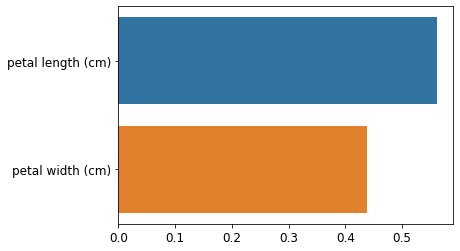

In [25]:
import seaborn as sns
import numpy as np

# feature_importance 추출
print("Feature importances:\n{0}".format(np.round(tree_clf.feature_importances_, 3)))

# feature 별 importance 매핑
for name, value in zip(iris.feature_names[2:], tree_clf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))
    
# feature importance를 column 별로 시각화하기
sns.barplot(x=tree_clf.feature_importances_, y=iris.feature_names[2:])

petal_length가 가장 피처 중요도가 높음을 알 수 있다.

일반적으로 다른 알고리즘이 블랙박스라고 불리듯이 알고리즘 내부의 동작 원리가 복잡한 데 반해 결정 트리는 알고리즘이 직관적이기 때문에 알고리즘과 관련된 요소를 시각적으로 표현할 수 있는 다양한 방안이 있다. 위에서 언급한 규칙 트리의 시각화와 feature_importances_ 속성을 통해 결정 트리 알고리즘이 어떻게 동작하는지 직관적으로 이해할 수 있다.

## CART 훈련 알고리즘

사이킷런은 결정 트리를 훈련시키기 위해(즉, 트리를 성장시키기 위해) CART<sup>classification and regression tree</sup> 알고리즘을 사용한다. 먼저 훈련 세트를 하나의 특성 $k$의 임곗값 $t_k$를 사용해 두 개의 서브셋으로 나눈다(예를 들면 꽃잎의 길이 ≤ 2.45cm). 어떻게 $k$와 $t_k$를 고를까? (크기에 따른 가중치가 적용된) 가장 순수한 서브셋으로 나눌 수 있는 ($k$, $t_k$) 짝을 찾는다. 이 알고리즘이 최소화해야 하는 비용 함수는 다음 식과 같다.

<b>분류에 대한 CART 비용 함수</b>
$$
\mathrm{J}(k, t_k) = \frac{n_{\mathrm{left}}}{n}G_{\mathrm{left}} + \frac{n_{\mathrm{right}}}{n}G_{\mathrm{right}}
$$

여기서 $G_{\mathrm{left/right}}$는 왼쪽/오른쪽 서브셋의 불순도를, $n_{\mathrm{left/right}}$는 왼쪽/오른쪽 서브셋의 샘플 수를 의미한다.

CART 알고리즘이 훈련 세트를 성공적으로 둘로 나누었다면 같은 방식으로 서브셋을 또 나누고 그다음엔 서브셋의 서브셋을 나누고 이런 식으로 계속 반복한다. 이 과정은 (max_depth 매개변수로 정의된) 최대 깊이가 되면 중지하거나 불순도를 줄이는 분할을 찾을 수 없을 때 멈추게 된다. (잣미 후에 살펴볼) 다른 몇 개의 매개변수도 중지 조건에 관여한다(min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes).

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: red"><strong>CAUTION_</strong></span> 여기에서 볼 수 있듯이 CART 알고리즘은 <b>탐욕적 알고리즘</b><sup>greedy algorithm</sup>이다. 맨 위 루트 노드에서 최적의 분할을 찾으며 이어지는 각 단계에서 이 과정을 반복한다. 현재 단계의 분할이 몇 단계를 거쳐 가장 낮은 불순도로 이어질 수 있을지 없을지는 고려하지 않는다. 탐욕적 알고리즘은 종종 납득할 만한 훌륭한 솔루션을 만들어낸다. 하지만 최적의 솔루션을 보장하지는 않는다.<br><br>불행하게도 최적의 트리를 찾는 것은 <b>NP-완전</b><sup>NP-Complete</sup>문제로 알려져 있다. 이 문제는 $O(\mathrm{exp}(n))$ 시간이 필요하고 매우 작은 훈련 세트에도 적용하기 어렵다. 그러므로 '납득할 만한 좋은 솔루션'으로만 만족해야 한다.</div>

## 정보 이득 최대화: 자원을 최대로 활용

가장 정보가 풍부한 특성으로 노드를 나누기 위해 트리 알고리즘으로 최적화할 목적함수를 정의한다. 이 목적 함수는 각 분할에서 정보 이득을 최대화한다. 정보 이득은 다음과 같이 정의한다.

$$
IG(D_p, f) = I(D_p) - \sum_{j=1}^m\frac{N_j}{N_p}I(D_j)
$$

<ul>
    <li>$f$는 분할에 사용할 특성</li>
    <li>$D_p$와 $D_j$는 부모와 $j$번째 자식 노드의 데이터셋</li>
    <li>$I$는 <b>불순도</b><sup>impurity</sup> 지표</li>
    <li>$N_p$는 부모 노드에 있는 전체 샘플 개수</li>
    <li>$N_j$는 $j$번째 자식 노드에 있는 샘플 개수</li>
</ul>

여기서 볼 수 있듯이 정보 이득은 단순히 부모 노드의 불순도와 자식 노드의 불순도 합의 차이다. 자식 노드의 불순도가 낮을수록 정보 이득이 커진다. 구현을 간단하게 하고 탐색 공간을 줄이기 위해 (사이킷런을 포함해서) 대부분의 라이브러리는 이진 결정 트리를 사용한다. 즉, 부모 노드는 두 개의 자식 노드 $D_{\mathrm{left}}$와 $D_{\mathrm{right}}$로 나누어진다.

$$
IG(D_p, f) = I(D_p) - \frac{N_{\mathrm{left}}}{N_p}I(D_{\mathrm{left}}) - \frac{N_{\mathrm{right}}}{N_p}I(D_{\mathrm{right}})
$$

이진 결정 트리에서 널리 사용되는 세 개의 불순도 지표 또는 분할 조건은 <b>지니 불순도</b><sup>Gini impurity, $I_G$</sup>, <b>엔트로피</b><sup>entropy, $I_H$</sup>, <b>분류 오차</b><sup>classification error, $I_E$</sup>이다. 이 세 개의 불순도 지표를 다음 두 개의 분할 시나리오를 보면서 알아보도록 하자. 

<b>그림 3</b> 두 개의 분할 시나리오
<div style="text-align:center;">
    <img src="./images/decision_trees/두 개의 분할 시나리오.jpg">
</div>

### 엔트로피

샘플이 있는 모든 클래스 ($p(i|t)≠0$)에 대한 엔트로피 정의는 다음과 같다.

<b>엔트로피 정의</b>
$$
I_H(t) = -\sum_{i=1}^cp(i|t)\mathrm{log}_2p(i|t)
$$

여기서 $p(i|t)$는 특정 노드 $t$에서 클래스 $i$에 속한 샘플 비율이다. 한 노드의 모든 샘플이 같은 클래스이면 엔트로피는 0이 된다. 클래스 분포가 균등하면 엔트로피는 최대가 된다. 예를 들어 이진 클래스일 경우 $p(i=1|t)=1$ 또는 $p(i=0|t) = 0$이면 엔트로피는 0이다. 클래스가 $p(i=1|t)=0.5$와 $p(i=0|t)=0.5$처럼 균등하게 분포되어 있으면 엔트로피는 1이 된다. 엔트로피 조건을 트리의 상호 의존 정보를 최대화하는 것으로 이해할 수 있다.<sup><a id="a02" href="#p02">[2]</a></sup>

이제 [그림 3]의 시나리오로 엔트로피를 알아보자. 부모 노드에서 데이터셋 $D_p$로 시작한다. 이 데이터셋은 클래스 1이 40개의 샘플, 클래스 2가 40개의 샘플로 이루어져 있다. 이를 두 개의 데이터셋 $D_{\mathrm{left}}$와 $D_{\mathrm{right}}$로 나눈다.

엔트로피 기준으로 시나리오 $A(IG_H = 0.19)$보다 시나리오 $B(IG_H = 0.31)$를 선호한다.

$$
I_H(D_p) = -(0.5\mathrm{log}_2(0.5) + 0.5\mathrm{log}_2(0.5)) = 1
$$

$$
A: I_H(D_{\mathrm{left}}) = -(\frac{3}{4}\mathrm{log}_2(\frac{3}{4}) + \frac{1}{4}\mathrm{log}_2(\frac{1}{4})) = 0.81
$$

$$
A: I_H(D_{\mathrm{right}}) = -(\frac{1}{4}\mathrm{log}_2(\frac{1}{4}) + \frac{3}{4}\mathrm{log}_2(\frac{3}{4})) = 0.81
$$

$$
A: IG_H = 1 - \frac{40}{80}0.81 - \frac{40}{80}0.81 = 0.19
$$

$$
B: I_H(D_{\mathrm{left}}) = -(\frac{2}{6}\mathrm{log}_2(\frac{2}{6}) + \frac{4}{6}\mathrm{log}_2(\frac{4}{6})) = 0.92
$$

$$
B: I_H(D_{\mathrm{right}}) = 0 
$$

$$
B: IG_H = 1 - \frac{6}{8}0.92 - 0 = 0.31
$$

### 지니 불순도

자연스럽게 지니 불순도는 잘못 분류될 확률을 최소화하기 위한 기준으로 이해할 수 있다.

<b>지니 불순도 정의</b>
$$
I_G(t) = \sum_{i=1}^cp(i|t)(1-p(i|t)) = 1 - \sum_{i=1}^cp(i|t)^2
$$

엔트로피와 비슷하게 지니 불순도는 클래스가 완벽하게 섞여 있을 때 최대가 된다. 예를 들어 이진 클래스 환경($c=2$)에서는 다음과 같다.

$$
I_G(t) = 1 - \sum_{i=1}^{c}0.5^2 = 0.5
$$

실제로는 지니 불순도와 엔트로피 모두 매우 비슷한 결과가 나온다. 보통 불순도 조건을 바꾸어 트리를 평가하는 것보다 가지치기 수준을 바꾸면서 튜닝하는 것이 훨씬 낫다.

지니 불순도는 시나리오 $A(IG_G = 0.125)$보다 시나리오 $B(IG_G = 0.1\dot6)$가 더 순수하기 때문에 값이 높다.

$$
I_G(D_p) = 1 - (0.5^2 + 0.5^2) = 0.5
$$

$$
A: I_G(D_{\mathrm{left}}) = 1 - ((\frac{3}{4})^2 + (\frac{1}{4})^2) = \frac{3}{8} = 0.375
$$

$$
A: I_G(D_{\mathrm{right}}) = 1 - ((\frac{1}{4})^2 + (\frac{3}{4})^2) = \frac{3}{8} = 0.375
$$

$$
A: IG_G = 0.5 - \frac{40}{80}0.375 - \frac{40}{80}0.375 = 0.125
$$

$$
B: I_G(D_{\mathrm{left}}) = 1 - ((\frac{2}{6})^2 + (\frac{4}{6})^2) = \frac{4}{9} = 0.\dot4
$$

$$
B: I_G(D_{\mathrm{right}}) = 1 - (1^2 + 0^2) = 0
$$

$$
B: IG_G = 0.5 - \frac{60}{80}0.\dot4 - 0 = 0.1\dot6
$$

### 분류 오차

또 다른 불순도 지표는 분류 오차다.<sup><a id="a03" href="#p03">[3]</a></sup>

$$
I_E = 1 - \mathrm{max}\left\{p(i|t)\right\}
$$

가지치기에는 좋은 기준이지만 결정 트리를 구성하는 데는 권장되지 않는다. 노드의 클래스 확률 변화에 덜 민감하기 때문이다.

분류 오차를 분할 기준으로 사용했을 때 정보 이득은 시나리오 $A\cdot B$가 동일하다($IG_E = 0.25$).

$$
I_E(D_p) = 1 - 0.5 = 0.5
$$

$$
A: I_E(D_{\mathrm{left}}) = 1 - \frac{3}{4} = 0.25
$$

$$
A: I_E(D_{\mathrm{right}}) = 1 - \frac{3}{4} = 0.25
$$

$$
A: IG_E = 0.5 - \frac{40}{80}0.25 - \frac{40}{80}0.25 = 0.25
$$

$$
B: I_E(D_{\mathrm{left}}) = 1 - \frac{4}{6} = \frac{1}{3}
$$

$$
B: I_E(D_{\mathrm{right}}) = 1 - 1 = 0
$$

$$
B: IG_E = 0.5 - \frac{60}{80}\times\frac{1}{3} - 0 = 0.25
$$

### 종합

앞서 나온 세 개의 불순도 기준을 시각적으로 비교하기 위해 클래스 1의 확률 범위 [0, 1]에 대한 불순도 인덱스를 그려 보겠다. 지니 불순도가 엔트로피와 분류 오차의 중간임을 관찰하기 위해 스케일 조정된 엔트로피(entropy / 2)를 추가하겠다. 코드는 다음과 같다.

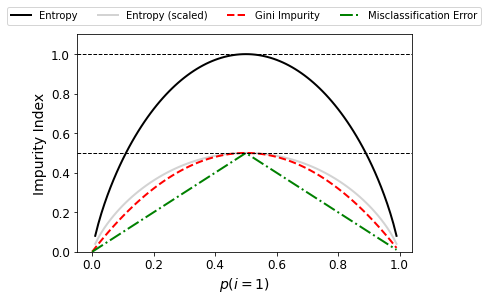

In [18]:
import matplotlib.pyplot as plt
import numpy as np
def gini(p):
    return p * (1 - (p)) + (1 - p) * (1 - (1 - p))
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))
def error(p):
    return 1 - np.max([p, 1 - p])
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                         ['Entropy', 'Entropy (scaled)',
                          'Gini Impurity',
                          'Misclassification Error'],
                         ['-', '-', '--', '-.'],
                         ['black', 'lightgray',
                          'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab,
                   linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel(r'$p(i=1)$')
plt.ylabel('Impurity Index')
plt.show()

그렇다면 지니 불순도와 엔트로피 중 어떤 것을 사용해야 할까? 실제로는 큰 차기 없다. 즉, 둘 다 비슷한 트리를 만들어낸다. 지니 불순도가 조금 더 계산이 빠르기 때문에 기본값으로 좋다. 그러나 다른 트리가 만들어지는 경우 지니 불순도가 가장 빈도 높은 클래스를 한쪽 가지<sup>branch</sup>로 고립시키는 경향이 있는 반면 엔트로피는 조금 더 균형 잡힌 트리를 만든다.

## 계산 복잡도

예측을 하려면 결정 트리를 루트 노드에서부터 리프 노드까지 탐색해야 한다. 일반적으로 결정 트리는 거의 균형을 이루고 있으므로 결정 트리를 탐색하기 위해서는 약 $O(\mathrm{log}_2(n))$개의 노드를 거쳐야 한다.<sup><a id="a01" href="#p01">[1]</a></sup> 각 노드는 하나의 특성값만 확인하기 때문에 예측에 필요한 전체 복잡도는 특성 수와 무관하게 $O(\mathrm{log}_2(n))$이다. 그래서 큰 훈련 세트를 다룰 때도 예측 속도가 매우 빠르다.

훈련 알고리즘은 각 노드에서 모든 훈련 샘플의 모든 (또는 max_features가 지정되었다면 그보다는 적은)특성을 비교한다. 각 노드에서 모든 샘플의 모든 특성을 비교하면 훈련 복잡도는 $O(m\,\times n\mathrm{log}_2(n))$이 된다. 훈련 세트가 (수천 개 이하의 샘플 정도로) 작을 경우 사이킷런은 (presort=True로 지정하면) 미리 데이터를 정렬하여 훈련 속도를 높일 수 있다. 하지만 훈련 세트가 클 경우에는 속도가 많이 느려진다.

## 규제 매개변수

결정 트리는 훈련 데이터에 대한 제약 사항이 거의 없다(반대로 선형 모델은 데이터가 선형일 거라 가정한다). 제한을 두지 않으면 트리가 훈련 데이터에 아주 가깝게 맞추려고 해서 대부분 과대적합되기 쉽다. 결정 트리는 모델 파라미터가 전혀 없는 것이 아니라(보통 많다) 훈련되기 전에 파라미터 수가 결정되지 않기 때문에 이런 모델을 <b>비모수 모델</b><sup>nonparametric model</sup>이라고 부르곤 한다. 그래서 모델 구조가 데이터에 맞춰져서 고정되지 않고 자유롭다. 반대로 선형 모델 같은 <b>모수 모델</b><sup>parametric model</sup>은 미리 정의된 모델 파라미터 수를 가지므로 자유도가 제한되고 과대적합될 위험이 줄어든다(하지만 과소적합될 위험은 커진다).

훈련 데이터에 대한 과대적합을 피하기 위해 학습할 때 결정 트리의 자유도를 제한할 필요가 있다. 이미 알고 있듯이 이를 규제라고 한다. 규제 매개변수는 사용하는 알고리즘에 따라 다르지만, 보통 적어도 결정 트리의 최대 깊이는 제어할 수 있다. 사이킷런에서는 max_depth 매개변수로 이를 조절한다(기본값은 제한이 없는 것을 의미하는 None이다). max_depth를 줄이면 모델을 규제하게 되고 과대적합의 위험이 감소한다.

DecisionTreeClassifier에는 비슷하게 결정 트리의 형태를 제한하는 다른 매개변수가 몇 개 있다.  min_으로 시작하는 매개변수를 증가시키거나 max_로 시작하는 매개변수를 감소시키면 모델의 규제가 커진다.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-tvz5{background-color:#cd9934;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-tvz5">파라미터 명</th>
    <th class="tg-tvz5">설명</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">min_samples_split</td>
    <td class="tg-0lax"><ul>
        <li>노드를 분할하기 위한 최소한의 샘플 데이터 수로 과대적합을 제어하는 데 사용됨</li>
        <li>디폴트는 2이고 작게 설정할수록 분할되는 노드가 많아져서 과대적합 가능성 증가</li>
        <li>과대적합을 제어. 1로 설정할 경우 분할되는 노그다 많아져서 과대적합 가능성 증가</li>
        </ul></td>
  </tr>
  <tr>
    <td class="tg-0lax">min_samples_leaf</td>
    <td class="tg-0lax"><ul>
        <li>리프 노드가 되기 위한 최소한의 샘플 데이터 수</li>
        <li>min_samples_split와 유사하게 과대적합 제어 용도. 그러나 비대칭적<sup>imbalanced</sup> 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있으므로 이 경우는 작게 설정 필요</li>
        </ul></td>
  </tr>
  <tr>
    <td class="tg-0lax">max_features</td>
    <td class="tg-0lax"><ul>
        <li>최적의 분할을 위해 고려할 최대 특성 개수. 디폴트는 None으로 데이터 세트의 모든 특성을 사용해 분할 수행</li>
        <li>int 형으로 지정하면 대상 특성의 개수, float 형으로 지정하면 전체 특성 중 대상 특성의 퍼센트</li>
        <li>'sqrt'는 전체 특성 중 sqrt(전체 특성 개수). 즉 $\sqrt{\text{전체 특성 개수}}$</li>
        <li>'auto'로 지정하면 sqrt와 동일</li>
        <li>'log'는 전체 특성 중 log2(전체 특성 개수) 선정</li>
        <li>'None'은 최대 특성 선정</li>
        </ul></td>
  </tr>
  <tr>
    <td class="tg-0lax">max_depth</td>
    <td class="tg-0lax"><ul>
        <li>트리의 최대 깊이를 규정</li>
        <li>디폴트는 None. None으로 설정하면 완벽하게 클래스 결정 값이 될 때까지 깊이를 계속 키우며 분할하거나 노드가 가지는 데이터 개수가 min_samples_split보다 작아질 때까지 계속 깊이를 증가시킴</li>
        <li>깊이가 깊어지면 min_samples_split 설정대로 최대 분할하여 과대적합할 수 있으므로 적절한 값으로 제어 필요</li>
        </ul></td>
  </tr>
  <tr>
    <td class="tg-0lax">max_leaf_nodes</td>
    <td class="tg-0lax"><ul>
        <li>리프 노드의 최대 개수</li>
        </ul></td>
  </tr>
</tbody>
</table>

[그림 4]은 moons 데이터셋에 훈련시킨 두 개의 결정 트리를 보여준다. 왼쪽 결정 트리는 기본 매개변수를 사용하여 훈련시켰고(즉, 규제가 없다). 오른쪽 결정 트리는 min_samples_leaf=4로 지정하여 훈련시켰다. 왼쪽 모델은 확실히 과대적합되었고 오른쪽 모델은 일반화 성능이 더 좋을 것 같아 보인다.

<b>그림 4</b> min_samples_leaf 매개변수를 사용한 규제
<div style="text-align:center;">
    <img src="./images/decision_trees/min_samples_leaf_plot.png">
</div>

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 제한 없이 결정 트리를 훈련시키고 불필요한 노드를 <b>가지치기</b><sup>pruning</sup>(제거)하는 알고리즘도 있다.<sup><a id="a04" href="#p04">[4]</a></sup> 순도를 높이는 것이 <b>통계적으로 큰 효과가 없다면</b> 리프 노드 바로 위의 노드는 불필요할 수 있다. 대표적으로 <b>$\chi^2$검정</b><sup>chi-squared test<a id="a05" href="#p05">[5]</a></sup> 같은 통계적 검정을 사용하여 우연히 향상된 것인지 추정한다(<b>귀무가설</b><sup>null hypothesis</sup>이라 부른다). 이 확률을 <b>p-값</b>이라 부르며 어떤 임곗값(하이퍼파라미터로 조정되지만 통상적으로 5%)보다 높으면 그 노드는 불필요한 것으로 간주되고 그 자식 노드는 삭제된다.<sup><a id="06" href="#p06">[6]</a></sup> 가지치기는 불필요한 노드가 모두 없어질 때까지 계속된다.
    </div>

## 회귀 트리

트리 기반의 회귀는 회귀 트리를 이용하는 것이다. 즉, 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측을 하는 것이다. 회귀 트리는 앞에서 언급했던 분류 트리와 크게 다르지 않다. 다만 리프 노드에서 예측 결정 값을 만드는 과정에 차이가 있는데, 분류 트리가 특정 클래스 레이블을 결정하는 것과는 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산한다.

사이킷런의 DecisionTreeRegressor를 사용해 잡음이 섞인 2차 함수 형태의 데이터셋에서 max_depth=2 설정으로 회귀 트리를 만들어보겠다.<sup><a id="a07" href="#p07">[7]</a></sup>

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

<b>그림 5</b> 회귀 결정 트리
<div style="text-align:center;">
    <img src="./images/decision_trees/회귀 결정 트리.png">
</div>

앞서 만든 분류 트리와 매우 비슷해 보인다. 주요한 차이는 각 노드에서 클래스를 예측하는 대신 어떤 값을 예측한다는 점이다. 예를 들어 $x_1 = 0.6$인 샘플의 타깃값을 예측한다고 가정해보자. 루트 노드부터 시작해서 트리를 순회하면 결국 value=0.111인 리프 노드에 도달하게 된다. 이 리프 노드에 있는 110개 훈련 샘플의 평균 타깃값이 예측값이 된다. 이 예측값을 사용해 110개 샘플에 대한 평균제곱오차<sup>MSE</sup>를 계산하면 0.015가 된다.

이 모델의 예측은 [그림 6]의 왼쪽에 나타나 있다. max_depth=3으로 설정하면 오른쪽 그래프와 같은 예측을 얻게 된다. 각 영역의 예측값은 항상 그 영역에 있는 타깃값의 평균이 된다. 알고리즘은 예측값과 가능한 한 많은 샘플이 가까이 있도록 영역을 분할한다.

<b>그림 6</b> 두 개의 결정 트리 회귀 모델의 예측
<div style="text-align:center;">
    <img src="./images/decision_trees/tree_regression_plot.png">
</div>

CART 알고리즘은 훈련 세트를 불순도를 최소화하는 방향으로 분할하는 대신 평균제곱오차<sup>MSE</sup>를 최소화하도록 분할하는 것을 제외하고는 앞서 설명한 것과 거의 비슷하게 작동한다. 다음 식은 알고리즘이 최소화하기 위한 비용 함수를 보여준다.

<b>회귀를 위한 CART 비용 함수</b>
$$
J(k, t_k) = \frac{n_{\mathrm{left}}}{n}\mathrm{MSE}_{\mathrm{left}} + \frac{n_{\mathrm{right}}}{n}\mathrm{MSE}_{\mathrm{right}}
$$

$$
\text{여기서}\left\{\begin{matrix}
\mathrm{MSE}_{\mathrm{node}} = \frac{1}{n_{\mathrm{node}}}\sum_{i\in \mathrm{node}}(\hat{y}_{\mathrm{node}} - y^{(i)})^2 \\
\hat{y}_{\mathrm{node}} = \frac{1}{n_{\mathrm{node}}}\sum_{i \in \mathrm{node}}y^{(i)}\end{matrix}\right.
$$

결정 트리 회귀에서는 MSE를 종종 <b>노드 내 분산</b><sup>within-node variance</sup>이라고도 한다. 이런 이유로 이 분할 기준을 <b>분산 감소</b><sup>variance reduction</sup>라고 많이 부른다.

분류에서와 같이 회귀 작업에서도 결정 트리가 과대적합되기 쉽다. 규제가 없다면(즉, 기본 매개변수를 사용하면) [그림 7]의 왼쪽과 같은 예측을 하게 된다. 이 예측은 확실히 훈련 세트에 아주 크게 과대적합되었다. min_samples_leaf=10으로 지정하면 [그림 7]의 오른쪽 그래프처럼 훨씬 그럴싸한 모델을 만들어준다.

<b>그림 7</b> 결정 트리 회귀 모델의 규제
<div style="text-align:center;">
    <img src="./images/decision_trees/tree_regression_regularization_plot.png">
</div>

## 불안정성

아마 결정 트리가 장점이 많다는 것을 알게 되었을 것이다. 결정 트리는 이해하고 해석하기 쉬우며, 사용하기 편하고, 여러 용도로 사용할 수 있으며, 성능도 뛰어나다. 하지만 몇 가지 제한 사항이 있다. 눈치 챘을지 모르겠지만 결정 트리는 계단 모양의 결정 경계를 만든다(모든 분할은 축에 수직이다). 그래서 훈련 세트의 회전에 민감하다. [그림 8]은 간단한 선형으로 구분될 수 있는 데이터셋을 예로 보여준다. 왼쪽의 결정 트리는 쉽게 데이터셋을 구분하지만, 데이터셋을 45˚ 회전한 오른쪽의 결정 트리는 불필요하게 구불구불해졌다. 두 결정 트리 모두 훈련 세트를 완벽하게 학습하지만 오른쪽 모델은 잘 일반화될 것 같지 않다. 이런 문제를 해결하는 한 가지 방법은 훈련 데이터를 더 좋은 방향으로 회전시키는 PCA 기법을 사용하는 것이다.

<b>그림 8</b> 훈련 세트의 회전에 민감한 결정 트리
<div style="text-align:center;">
    <img src="./images/decision_trees/sensitivity_to_rotation_plot.png">
</div>

결정 트리의 주된 문제는 훈련 데이터에 있는 작은 변화에도 매우 민감하다는 것이다. 예를 들어 훈련 세트에서 가장 넓은 Iris-Versicolor(꽃잎 길이가 4.8cm이고 너비가 1.8cm인 것)를 제거하고 결정 트리를 훈련시키면 [그림 9]와 같은 모델을 얻게 된다. 이전에 만든 결정 트리([그림 2])와는 매우 다른 모습이다. 사실 사이킷런에서 사용하는 훈련 알고리즘은 확률적이기 때문에<sup><a id="a08" href="#p08">[8]</a></sup> (random_state 매개변수를 지정하지 않으면) 같은 훈련 데이터에서도 다른 모델을 얻게 될 수 있다.

<b>그림 9</b> 훈련 세트의 세부사항에 민감한 결정 트리
<div style="text-align:center;">
    <img src="./images/decision_trees/decision_tree_instability_plot.png">
</div>

## 랜덤 포레스트로 여러 개의 결정 트리 연결

<b>랜덤 포레스트</b><sup>random forest</sup>는 뛰어난 분류 성능, 확장성, 쉬운 사용법 때문에 지난 10년간 머신러닝 애플리케이션에서 큰 인기를 누렸다. 랜덤 포레스트는 결정 트리의 <b>앙상블</b><sup>ensemble</sup>로 생각할 수 있다. 랜덤 포레스트 이면의 아이디어는 여러 개의 (깊은) 결정 트리를 평균 내는 것이다. 개개의 트리는 분산이 높은 문제가 있지만 앙상블은 견고한 모델을 만들어 일반화 성능을 높이고 과대적합의 위험을 줄인다. 랜덤 포레스트 알고리즘은 다음 네 단계로 요약할 수 있다.

<ol>
    <li>$n$개의 랜덤한 <b>부트스트랩</b><sup>bootstrap</sup> 샘플을 뽑는다(훈련 세트에서 중복을 허용하면서 랜덤하게 $n$개의 샘플을 선택한다).</li>
    <li>부트스트랩 샘플에서 결정 트리를 학습한다. 각 노드에서 다음과 같이 한다.
        <ol type="a">
            <li>중복을 허용하지 않고 랜덤하게 $d$개의 특성을 선택한다.</li>
            <li>정보 이득과 같은 목적 함수를 기준으로 최선의 분할을 만드는 특성을 사용해서 노드를 분할한다.</li>
        </ol></li>
    <li>단계 1, 2를 $k$번 반복한다.</li>
    <li>각 트리의 예측을 모아 <b>다수결 투표</b><sup>majority voting</sup>로 클래스 레이블을 할당한다.</li>
    </ol>

단계 2에서 각각의 결정 트리를 훈련할 때 조금 다른 점이 있다. 각 노드에서 최선의 분할을 찾기 위해 모든 특성을 평가하는 것이 아니라 랜덤하게 선택된 일부 특성만 사용한다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 중복을 허용한<sup>with replacement</sup> 샘플링과 허용하지 않는<sup>without replacement</sup> 샘플링에 익숙하지 않은 사람들을 위해 간단한 사고 실험을 해 보겠다. 뽑기 상자에서 랜덤하게 숫자를 고르는 제비 뽑기 게임을 가정해 보자. 뽑기 상자에는 다섯 개의 고유한 숫자 0, 1, 2, 3, 4가 들어 있다. 차례마다 딱 하나의 숫자만 뽑는다. 첫 번째 차례에서 상자에서 특정 숫자를 뽑을 확률은 $\frac{1}{5}$이다. 중복을 허용하지 않는 샘플링에서는 숫자를 뽑은 후 다시 상자에 넣지 않는다. 결과적으로 다음 차례에 남은 숫자에서 특정 숫자를 뽑을 확률은 이전에 뽑은 숫자에 따라 달라진다. 예를 들어 남은 숫자가 0, 1, 2, 4라면 다음 차례에 0을 뽑을 확률은 $\frac{1}{4}$이 된다.<br><br>
    중복을 허용한 랜덤 샘플링에서는 항상 뽑은 숫자를 다시 상자에 넣는다. 매 순서에서 특정 숫자를 뽑을 확률은 변하지 않게 된다. 동일한 숫자를 여러 번 뽑을 수 있다. 다른 말로 하면 중복을 허용한 샘플링은 샘플(숫자)이 독립적이고 공분산<sup>covariance</sup>이 0이다. 예를 들어 랜덤한 뽑기를 다섯 번 진행하여 나온 결과는 다음과 같다.
    <ul>
        <li><b>중복을 허용하지 않는 랜덤 샘플링:</b> 2, 1, 3, 4, 0</li>
        <li><b>중복을 허용한 랜덤 샘플링:</b> 1, 3, 3, 4, 1</li>
    </ul>
    </div>

랜덤 포레스트는 결정 트리만큼 해석이 쉽지 않지만 하이퍼파라미터 튜닝에 많은 노력을 기울이지 않아도 되는 것이 큰 장점이다. 일반적으로 랜덤 포레스트는 가지치기할 필요가 없다. 앙상블 모델이 개별 결정 트리가 만드는 잡음으로부터 매우 안정되어 있기 때문이다. 실전에서 신경 써야 할 파라미터는 랜덤 포레스트가 만들 트리 개수 $k$(단계 3) 하나다. 일반적으로 트리 개수가 많을수록 계산 비용이 증가하는 만큼 랜덤 포레스트 분류기의 성능이 좋아진다.

실전에서 자주 사용되지는 않지만 랜덤 포레스트 분류기에서 최적화할 만한 다른 하이퍼파라미터는 부트스트랩 샘플의 크기 $n$(단계 1)과 각 분할에서 무작위로 선택할 특성 개수 $d$(단계 2-A)이다. 하이퍼파라미터를 튜닝하는 기법은 후에 자세히 설명하겠다. 부트스트랩 샘플의 크기 $n$을 사용하면 랜덤 포레스트의 편향-분산 트레이드오프를 조절할 수 있다.

부트스트랩 샘플 크기가 작아지면 개별 트리의 다양성이 증가한다. 특정 훈련 샘플이 부트스트랩 샘플에 포함될 확률이 낮기 때문이다. 결국 부트스트랩 샘플 크기가 감소하면 랜덤 포레스트의 무작위성이 증가하고 과대적합의 영향이 줄어든다. 일반적으로 부트스트랩 샘플이 작을수록 랜덤 포레스트의 전체적인 성능이 줄어든다. 훈련 성능과 테스트 성능 사이에 격차가 작아지지만 전체적인 테스트 성능이 감소하기 때문이다. 반대로 부트스트랩 샘플 크기가 증가하면 과대적합 가능성이 늘어난다. 부트스트랩 샘플과 개별 결정 트리가 서로 비슷해지기 때문에 원본 훈련 데이터셋에 더 가깝게 학습된다.

사이킷런의 RandomForestClassifier를 포함하여 대부분의 라이브러리에서는 부트스트랩 샘플 크기를 원본 훈련 세트의 샘플 개수와 동일하게 한다. 보통 이렇게 하면 균형 잡힌 편향-분산 트레이드오프를 얻는다. 분할에 사용할 특성 개수 $d$는 훈련 세트에 있는 전체 특성 개수보다 작게 지정하는 편이다. 사이킷런과 다른 라이브러리에서 사용하는 적당한 기본값은 $d = \sqrt{m}$이다.<sup><a id="a09" href="#p09">[9]</a></sup>여기서 $m$은 훈련 세트에 있는 특성의 개수다.

사이킷런에 이미 준비되어 있기 때문에 직접 개별 결정 트리를 만들어 랜덤 포레스트 분류기를 구성할 필요가 없다.

<b>그림 10</b> 랜덤 포레스트가 학습한 붓꽃 데이터셋의 결정 경계
<div style="text-align:center;">
    <img src="./images/decision_trees/RandomForest_plot.png">
</div>

앞 코드에서 n_estimators 매개변수로 25개의 결정 트리를 사용하여 랜덤 포레스트를 훈련했다. 노드를 분할하는 불순도 지표는 지니 불순도를 사용했다. 작은 훈련 데이터셋에서 소규모 랜덤 포레스트를 훈련하지만 사용법을 보이기 위해 n_jobs 매개변수를 사용했다. 이 매개변수는 컴퓨터의 멀티 코어를 사용해서 모델 훈련을 병렬화한다(여기서는 두 개의 코어를 사용한다).

# 그림을 위한 코드

그림 저장: decision_tree_decision_boundaries_plot


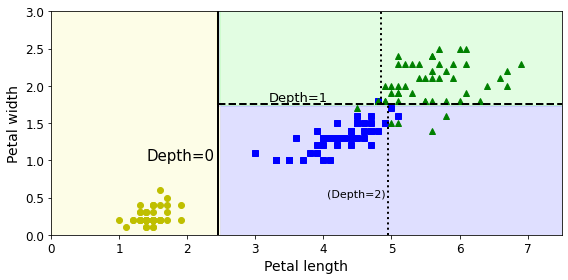

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

그림 저장: min_samples_leaf_plot


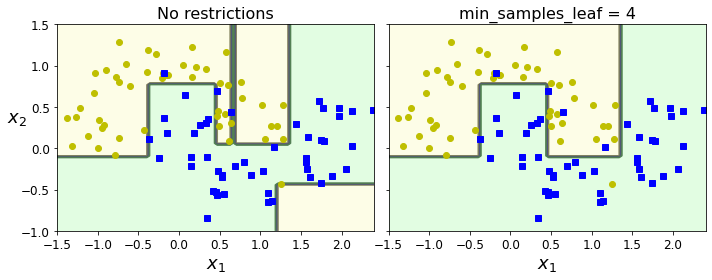

In [21]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=16)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

In [22]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [23]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

그림 저장: tree_regression_plot


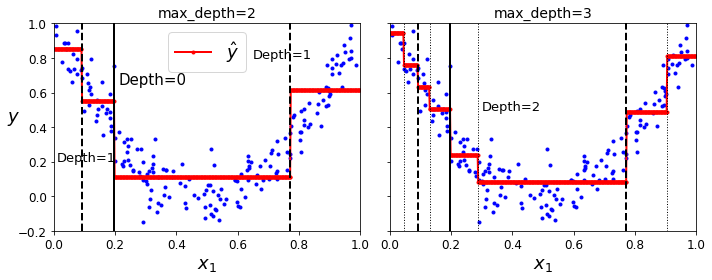

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

In [ ]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

In [ ]:
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

그림 저장: tree_regression_regularization_plot


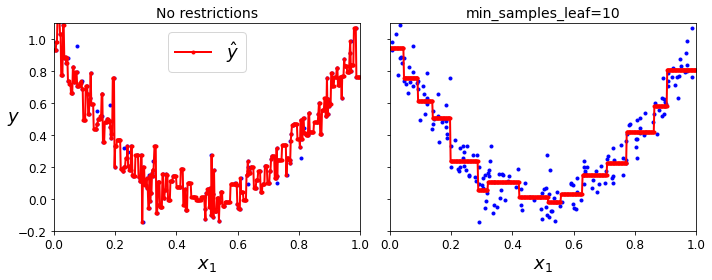

In [39]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

그림 저장: sensitivity_to_rotation_plot


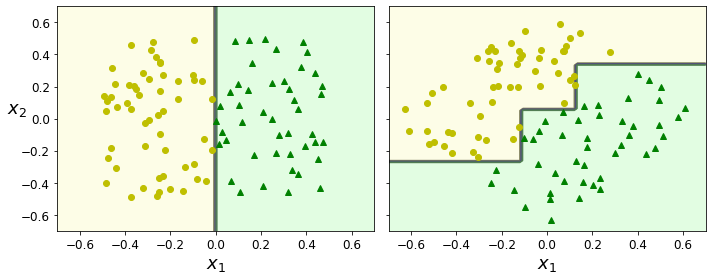

In [42]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

In [45]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=40)

그림 저장: decision_tree_instability_plot


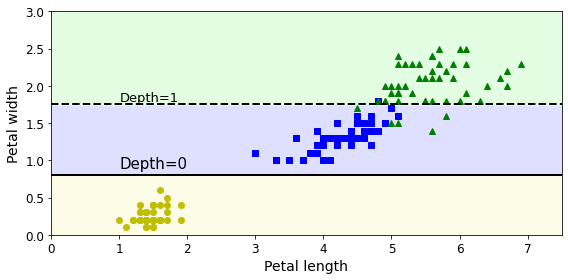

In [47]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

그림 저장: RandomForest_plot


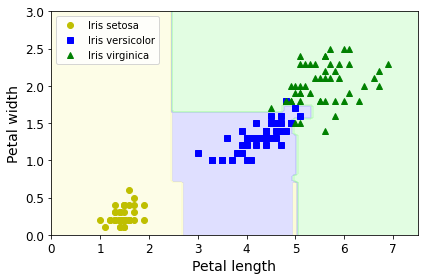

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25,
                                random_state=1,
                                n_jobs=2)
forest.fit(X, y)
plot_decision_boundary(forest, X, y, legend=True)
plt.legend(loc='upper left')
save_fig('RandomForest_plot')
plt.show()

# 미주

<b id="p01">1</b> $\mathrm{log}_2$는 밑이 2인 로그이므로 $\mathrm{log}_2(n) = \mathrm{log}(n) / \mathrm{log}(2)$이다. 균형 이진 트리에서 깊이 $d$에서의 리프 노드의 개수는 $2^d$다. 리프 노드가 훈련 데이터 수($n$)만큼 있다면 이 트리의 깊이는 $\mathrm{log}_2(n)$이 된다. [↩](#a01)

<b id="p02">2</b> $\mathrm{log}_2(0.5)=-1$이므로 두 노드가 균등하게 분포되어 있으면 $I_H(t) = -(0.5 * (-1) + 0.5 * (-1)) = 1$이 된다. [↩](#a02)

<b id="p03">3</b> 분류 오차 불순도 지표도 마찬가지로 두 클래스가 같은 비율일 때 최대(0.5)가 되고 한 클래스의 비율이 커질수록 줄어든다. [↩](#a03)

<b id="p04">4</b> 이런 방식을 사후 가지치기<sup>post-pruning</sup>라고 한다. 이 외에도 분할로 얻어질 최소한의 불순도 감소량을 지정하는 min_impurity_decrease가 추가되었다. [↩](#a04)

<b id="p05">5</b> 카이제곱 검정은 sklearn.feature_selection.chi2 함수에 구현되어 있다. 카이제곱의 값이 커지면 p-값은 줄어든다. [↩](#a05)

<b id="p06">6</b> p-값이 임곗값보다 높으면 순도 향상이 우연에 의한 것일 수 있다고 본다. [↩](#a06)

<b id="p07">7</b> 이 코드에 있는 훈련 데이터는 $y=4(x - 0.5)^2$을 사용하여 만들었으며 $y$ 값에 랜덤한 잡음을 섞었다. [↩](#a07)

<b id="p08">8</b> 각 노드에서 평가할 후보 특성을 무작위로 선택한다. DecisionTreeClassifier와 DecisionTreeRegressor는 max_features 매개변수에서 분할에 사용할 특성의 최대 개수를 지정할 수 있다. 데이터셋의 특성 개수보다 작게 설정하면 무작위로 일부 특성이 선택된다. 기본값은 None으로 전체 특성 개수가 사용된다. [↩](#a08)

<b id="p09">9</b> RandomForestClassifier() 클래스의 max_features 매개변수 기본값이 'auto'로 특성 개수의 제곱근이다. 랜덤 포레스트의 회귀를 구현한 RandomForestRegressor 클래스의 max_features 기본값은 훈련 세트의 특성 개수와 동일하다. [↩](#a09)